In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

logger = logging.getLogger(__name__)

### SETUP

In [2]:
# Load precomputed data

MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

initial_values['SM1A'] *= 1.01
initial_values['SM1B'] *= 1.008

# optimizer variables in units of K2L
variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
# variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    # variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

objectives_active = {'LT': 'MAXIMIZE', 'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

# Manual modifications
initial_variable_values['SH1'] -= 0.2
initial_variable_values['SH3'] -= 0.08
initial_variable_values['SL2'] -= 0.5
initial_variable_values['SL3'] -= 0.5

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.6 -0.396658 -0.117102 -0.316418 -0.265432 -0.713558 -0.589217
1   0.6  0.396658  0.117102  0.316418  0.265432  0.713558  0.589217


In [3]:
reference_point = {'LT': 4.0, # hours
                   'EFF': 50.0 # % injected
                   }

In [4]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

In [5]:
#TEST = True
TEST = False

if TEST:
    from opt_funcs_nsls import make_dummy_eval
    eval_f = make_dummy_eval(gvocs)
else:
    sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-26_APSU_DA_MA")
    import opt_funcs

    def knobs_to_family(inputs_dict):
        d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
        return opt_funcs.master_eval_function(d, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

    eval_f = knobs_to_family

In [6]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.265 -> -2.920
SL2: 7.136 + -0.714 -> 6.422
SL3: -5.892 + -0.589 -> -6.481
SH1: 3.967 + -0.397 -> 3.570
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.783 + 0.398 -> -4.385
SM1B: -5.231 + -0.447 -> -5.678
SM2B: 7.161 + 0.052 -> 7.213


{'SL1': -2.9197533310000003,
 'SL2': 6.422025861000001,
 'SL3': -6.481389334200001,
 'SH1': 3.5699241780000004,
 'SH3': -1.2881238501999999,
 'SH4': -3.4805981562,
 'SM1A': -4.385288760620001,
 'SM1B': -5.6776103901960004,
 'SM2B': 7.2127339758749995}

In [7]:
if True:
    opt_funcs.master_eval_function(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

Sextupole adj. took 9.5.
RMS(dx, dy) [m] = (1.385e-04, 4.436e-06)
RMS(dx, dy) [m] = (6.286e-05, 5.053e-06)
RMS(dx, dy) [m] = (4.626e-05, 3.244e-06)
RMS(dx, dy) [m] = (2.188e-05, 1.943e-06)
RMS(dx, dy) [m] = (1.141e-05, 2.699e-06)
RMS(dx, dy) [m] = (7.910e-06, 4.541e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 2.953 (raw tau [hr] = 3.435, epsy [pm] = 16.84) (took 3.9 [s])
Inj. Eff. = 36.08 (took 23.2 [s])
Eval. func. finished.
Eval. func. finished.


In [8]:
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 128 #512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
#gen.max_travel_distances = [0.1] * len(gvocs.variables_active)
gen.reference_point = reference_point

In [9]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

### Sample at initial values

In [10]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + -0.500 -> 6.636
SL3: -5.892 + -0.500 -> -6.392
SH1: 3.967 + -0.200 -> 3.767
SH3: -1.171 + -0.080 -> -1.251
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.783 + 0.000 -> -4.783
SM1B: -5.231 + 0.000 -> -5.231
SM2B: 7.161 + 0.000 -> 7.161
Sextupole adj. took 5.3.
RMS(dx, dy) [m] = (1.007e-04, 3.813e-06)
RMS(dx, dy) [m] = (5.750e-05, 3.903e-06)
RMS(dx, dy) [m] = (2.770e-05, 3.531e-06)
RMS(dx, dy) [m] = (1.437e-05, 2.437e-06)
RMS(dx, dy) [m] = (8.472e-06, 9.710e-07)
Orbit correction converged
** # of outliers found = 5 (out of 180)
Lifetime = 3.575 (raw tau [hr] = 4.166, epsy [pm] = 16.79) (took 3.4 [s])
Inj. Eff. = 1.65 (took 16.0 [s])
Eval. func. finished.
Eval. func. finished.


In [22]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + 0.000 -> 7.136
SL3: -5.892 + 0.000 -> -5.892
SH1: 3.967 + 0.000 -> 3.967
SH3: -1.171 + 0.000 -> -1.171
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.783 + 0.000 -> -4.783
SM1B: -5.231 + 0.000 -> -5.231
SM2B: 7.161 + 0.000 -> 7.161
Sextupole adj. took 3.2.
RMS(dx, dy) [m] = (8.566e-05, 4.104e-06)
RMS(dx, dy) [m] = (1.398e-04, 8.843e-06)
RMS(dx, dy) [m] = (3.763e-05, 3.572e-06)
RMS(dx, dy) [m] = (2.031e-05, 4.303e-06)
RMS(dx, dy) [m] = (1.092e-05, 3.465e-06)
RMS(dx, dy) [m] = (5.033e-06, 1.095e-06)
Orbit correction converged
** # of outliers found = 6 (out of 180)
Lifetime = 5.815 (raw tau [hr] = 7.078, epsy [pm] = 17.68) (took 4.5 [s])
Inj. Eff. = 85.41 (took 18.4 [s])
Eval. func. finished.
Eval. func. finished.


In [12]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.0,-0.2,-0.08,0.0,0.0,-0.5,-0.5,"{'_nux': 0.21099733959289255, '_nuy': 0.268644...",None,,...,True,0.210997,0.268645,2.264683e-09,1.708862e-11,2.263759e-09,1.678668e-11,3.575129,4.166117,1.647341
2,0.0,-0.2,-0.08,0.0,0.0,-0.5,-0.5,"{'_nux': 0.21099733959289255, '_nuy': 0.268370...",None,,...,True,0.210997,0.268370,2.266347e-09,1.680131e-11,2.262876e-09,1.669104e-11,3.672483,4.274899,1.806105


### Sample close to initial point

In [13]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

SL1: -2.654 + 0.010 -> -2.644
SL2: 7.136 + -0.524 -> 6.612
SL3: -5.892 + -0.502 -> -6.394
SH1: 3.967 + -0.196 -> 3.770
SH3: -1.171 + -0.081 -> -1.252
SH4: -3.164 + -0.004 -> -3.168
SM1A: -4.783 + -0.010 -> -4.794
SM1B: -5.231 + 0.012 -> -5.219
SM2B: 7.161 + -0.001 -> 7.159
Sextupole adj. took 0.1.
RMS(dx, dy) [m] = (1.766e-06, 4.348e-07)
Orbit correction converged
** # of outliers found = 2 (out of 180)
Lifetime = 3.678 (raw tau [hr] = 4.283, epsy [pm] = 16.69) (took 4.0 [s])
Inj. Eff. = 1.93 (took 16.0 [s])
Eval. func. finished.
Eval. func. finished.


In [14]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,0.000000,-0.200000,-0.080000,0.000000,0.000000,-0.500000,-0.500000,"{'_nux': 0.21099733959289255, '_nuy': 0.268644...",None,,...,True,0.210997,0.268645,2.264683e-09,1.708862e-11,2.263759e-09,1.678668e-11,3.575129,4.166117,1.647341
2,0.000000,-0.200000,-0.080000,0.000000,0.000000,-0.500000,-0.500000,"{'_nux': 0.21099733959289255, '_nuy': 0.268370...",None,,...,True,0.210997,0.268370,2.266347e-09,1.680131e-11,2.262876e-09,1.669104e-11,3.672483,4.274899,1.806105
3,0.015514,-0.196213,-0.081386,-0.003579,0.009994,-0.523752,-0.501679,"{'_nux': 0.21099733959289255, '_nuy': 0.268309...",None,,...,True,0.210997,0.268309,2.252518e-09,1.682469e-11,2.254053e-09,1.668708e-11,3.678472,4.283441,1.925223


### Run optimizer

In [16]:
opt.step()

/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/botorch/optim/initializers.py:404: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


SL1: -2.654 + -0.124 -> -2.779
SL2: 7.136 + -0.439 -> 6.697
SL3: -5.892 + 0.222 -> -5.670
SH1: 3.967 + -0.106 -> 3.861
SH3: -1.171 + 0.087 -> -1.084
SH4: -3.164 + -0.116 -> -3.280
SM1A: -4.783 + 0.343 -> -4.441
SM1B: -5.231 + -0.385 -> -5.615
SM2B: 7.161 + 0.045 -> 7.206
Sextupole adj. took 7.3.
RMS(dx, dy) [m] = (7.076e-05, 5.198e-06)
RMS(dx, dy) [m] = (3.575e-04, 2.463e-05)
RMS(dx, dy) [m] = (3.460e-05, 3.173e-06)
RMS(dx, dy) [m] = (1.283e-04, 1.635e-05)
RMS(dx, dy) [m] = (8.787e-06, 1.997e-06)
Orbit correction converged
** # of outliers found = 2 (out of 180)
Lifetime = 6.390 (raw tau [hr] = 7.456, epsy [pm] = 16.73) (took 5.0 [s])
Inj. Eff. = 7.14 (took 18.1 [s])
Eval. func. finished.
Eval. func. finished.


In [23]:
for i in range(10):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()


** Step #1 at 2023-11-26 21:30:41**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.037 -> -2.691
SL2: 7.136 + -0.014 -> 7.122
SL3: -5.892 + 0.110 -> -5.782
SH1: 3.967 + 0.056 -> 4.023
SH3: -1.171 + 0.017 -> -1.154
SH4: -3.164 + -0.010 -> -3.174
SM1A: -4.783 + -0.104 -> -4.888
SM1B: -5.231 + 0.117 -> -5.114
SM2B: 7.161 + -0.014 -> 7.147
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (2.229e-05, 9.095e-07)
RMS(dx, dy) [m] = (2.104e-05, 2.761e-06)
RMS(dx, dy) [m] = (1.089e-05, 6.511e-07)
RMS(dx, dy) [m] = (5.159e-06, 1.199e-06)
Orbit correction converged
** # of outliers found = 7 (out of 180)
Lifetime = 5.817 (raw tau [hr] = 7.088, epsy [pm] = 17.68) (took 5.4 [s])
Inj. Eff. = 82.76 (took 19.2 [s])
Eval. func. finished.
Eval. func. finished.

** Step #2 at 2023-11-26 21:31:22**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.017 -> -2.671
SL2: 7.136 + 0.091 -> 7.227
SL3: -5.892 + 0.100 -> -5.793
SH1: 3.967 + 0.024 -> 3.991
SH3: -1.171 + 0.016 -> -1.155
SH4: -3.164 + -0.023 -> -3.187
SM1A: -4.783 + 0.028 -> -4.756
SM1B: -5.231 + -0.031 -> -5.262
SM2B: 7.161 + 0.004 -> 7.164
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (2.247e-05, 9.195e-07)
RMS(dx, dy) [m] = (7.207e-05, 5.659e-06)
RMS(dx, dy) [m] = (1.469e-05, 1.375e-06)
RMS(dx, dy) [m] = (3.170e-05, 2.024e-06)
RMS(dx, dy) [m] = (5.837e-06, 1.088e-06)
Orbit correction converged
** # of outliers found = 2 (out of 180)
Lifetime = 6.022 (raw tau [hr] = 7.359, epsy [pm] = 17.76) (took 5.1 [s])
Inj. Eff. = 82.00 (took 19.9 [s])
Eval. func. finished.
Eval. func. finished.

** Step #3 at 2023-11-26 21:32:07**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + 0.068 -> -2.586
SL2: 7.136 + 0.057 -> 7.193
SL3: -5.892 + 0.043 -> -5.849
SH1: 3.967 + 0.070 -> 4.036
SH3: -1.171 + 0.027 -> -1.144
SH4: -3.164 + -0.003 -> -3.167
SM1A: -4.783 + -0.047 -> -4.830
SM1B: -5.231 + 0.052 -> -5.179
SM2B: 7.161 + -0.006 -> 7.155
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (3.665e-05, 2.132e-06)
RMS(dx, dy) [m] = (3.042e-04, 1.139e-05)
RMS(dx, dy) [m] = (9.507e-06, 7.453e-07)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 5.850 (raw tau [hr] = 7.148, epsy [pm] = 17.72) (took 5.6 [s])
Inj. Eff. = 77.23 (took 19.9 [s])
Eval. func. finished.
Eval. func. finished.

** Step #4 at 2023-11-26 21:32:46**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.048 -> -2.703
SL2: 7.136 + 0.089 -> 7.225
SL3: -5.892 + 0.032 -> -5.860
SH1: 3.967 + 0.016 -> 3.983
SH3: -1.171 + -0.003 -> -1.174
SH4: -3.164 + -0.034 -> -3.198
SM1A: -4.783 + -0.052 -> -4.836
SM1B: -5.231 + 0.059 -> -5.172
SM2B: 7.161 + -0.007 -> 7.154
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (9.224e-07, 6.649e-07)
Orbit correction converged
** # of outliers found = 10 (out of 180)
Lifetime = 5.786 (raw tau [hr] = 7.074, epsy [pm] = 17.70) (took 6.6 [s])
Inj. Eff. = 80.84 (took 18.5 [s])
Eval. func. finished.
Eval. func. finished.

** Step #5 at 2023-11-26 21:33:20**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.052 -> -2.706
SL2: 7.136 + -0.018 -> 7.117
SL3: -5.892 + 0.056 -> -5.836
SH1: 3.967 + 0.099 -> 4.066
SH3: -1.171 + 0.005 -> -1.166
SH4: -3.164 + 0.016 -> -3.148
SM1A: -4.783 + 0.081 -> -4.703
SM1B: -5.231 + -0.091 -> -5.322
SM2B: 7.161 + 0.011 -> 7.171
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (5.319e-05, 1.749e-06)
RMS(dx, dy) [m] = (1.729e-04, 1.051e-05)
RMS(dx, dy) [m] = (1.124e-05, 1.129e-06)
RMS(dx, dy) [m] = (2.422e-05, 1.689e-06)
RMS(dx, dy) [m] = (5.353e-06, 1.790e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 6.167 (raw tau [hr] = 7.552, epsy [pm] = 17.73) (took 6.1 [s])
Inj. Eff. = 83.70 (took 19.3 [s])
Eval. func. finished.
Eval. func. finished.

** Step #6 at 2023-11-26 21:34:05**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.061 -> -2.716
SL2: 7.136 + 0.040 -> 7.176
SL3: -5.892 + 0.048 -> -5.844
SH1: 3.967 + 0.002 -> 3.969
SH3: -1.171 + 0.022 -> -1.149
SH4: -3.164 + 0.055 -> -3.109
SM1A: -4.783 + 0.041 -> -4.742
SM1B: -5.231 + -0.046 -> -5.277
SM2B: 7.161 + 0.005 -> 7.166
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (9.348e-07, 8.338e-07)
Orbit correction converged
** # of outliers found = 9 (out of 180)
Lifetime = 6.113 (raw tau [hr] = 7.499, epsy [pm] = 17.76) (took 6.6 [s])
Inj. Eff. = 83.96 (took 20.0 [s])
Eval. func. finished.
Eval. func. finished.

** Step #7 at 2023-11-26 21:34:40**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.005 -> -2.660
SL2: 7.136 + 0.007 -> 7.142
SL3: -5.892 + 0.064 -> -5.828
SH1: 3.967 + 0.019 -> 3.985
SH3: -1.171 + -0.014 -> -1.185
SH4: -3.164 + 0.054 -> -3.111
SM1A: -4.783 + 0.046 -> -4.737
SM1B: -5.231 + -0.052 -> -5.283
SM2B: 7.161 + 0.006 -> 7.167
Sextupole adj. took 0.1.
RMS(dx, dy) [m] = (6.737e-07, 4.663e-07)
Orbit correction converged
** # of outliers found = 6 (out of 180)
Lifetime = 5.870 (raw tau [hr] = 7.214, epsy [pm] = 17.79) (took 6.0 [s])
Inj. Eff. = 81.84 (took 18.7 [s])
Eval. func. finished.
Eval. func. finished.

** Step #8 at 2023-11-26 21:35:11**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.051 -> -2.706
SL2: 7.136 + -0.061 -> 7.075
SL3: -5.892 + 0.052 -> -5.840
SH1: 3.967 + 0.006 -> 3.973
SH3: -1.171 + 0.029 -> -1.142
SH4: -3.164 + 0.006 -> -3.159
SM1A: -4.783 + 0.090 -> -4.694
SM1B: -5.231 + -0.101 -> -5.332
SM2B: 7.161 + 0.012 -> 7.173
Sextupole adj. took 0.1.
RMS(dx, dy) [m] = (2.435e-06, 1.452e-06)
Orbit correction converged
** # of outliers found = 3 (out of 180)
Lifetime = 5.941 (raw tau [hr] = 7.310, epsy [pm] = 17.81) (took 6.1 [s])
Inj. Eff. = 82.16 (took 18.7 [s])
Eval. func. finished.
Eval. func. finished.

** Step #9 at 2023-11-26 21:35:43**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.090 -> -2.744
SL2: 7.136 + 0.113 -> 7.248
SL3: -5.892 + 0.102 -> -5.790
SH1: 3.967 + 0.133 -> 4.099
SH3: -1.171 + 0.020 -> -1.151
SH4: -3.164 + 0.036 -> -3.128
SM1A: -4.783 + 0.053 -> -4.731
SM1B: -5.231 + -0.059 -> -5.290
SM2B: 7.161 + 0.007 -> 7.168
Sextupole adj. took 2.1.
RMS(dx, dy) [m] = (5.906e-05, 2.376e-06)
RMS(dx, dy) [m] = (1.591e-05, 2.445e-06)
RMS(dx, dy) [m] = (8.506e-06, 1.501e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 6.051 (raw tau [hr] = 7.450, epsy [pm] = 17.81) (took 5.1 [s])
Inj. Eff. = 74.81 (took 18.4 [s])
Eval. func. finished.
Eval. func. finished.

** Step #10 at 2023-11-26 21:36:22**



/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


SL1: -2.654 + -0.038 -> -2.692
SL2: 7.136 + -0.027 -> 7.108
SL3: -5.892 + 0.035 -> -5.857
SH1: 3.967 + 0.036 -> 4.002
SH3: -1.171 + 0.010 -> -1.161
SH4: -3.164 + 0.011 -> -3.153
SM1A: -4.783 + 0.013 -> -4.771
SM1B: -5.231 + -0.014 -> -5.245
SM2B: 7.161 + 0.002 -> 7.162
Sextupole adj. took 1.1.
RMS(dx, dy) [m] = (5.823e-07, 9.806e-07)
Orbit correction converged
** # of outliers found = 7 (out of 180)
Lifetime = 5.940 (raw tau [hr] = 7.319, epsy [pm] = 17.81) (took 6.6 [s])
Inj. Eff. = 85.28 (took 18.7 [s])
Eval. func. finished.
Eval. func. finished.


In [24]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
22,-0.062296,0.002058,0.021632,0.054942,-0.061211,0.040408,0.047984,"{'_nux': 0.21758909367793444, '_nuy': 0.256712...",None,,...,True,0.217589,0.256712,2.185375e-09,1.835336e-11,2.235183e-09,1.775722e-11,6.113263,7.499236,83.959710
23,-0.070043,0.018622,-0.014069,0.053570,-0.005426,0.006601,0.064412,"{'_nux': 0.21592081434218158, '_nuy': 0.260313...",None,,...,True,0.215921,0.260313,2.221827e-09,1.823417e-11,2.235027e-09,1.779191e-11,5.869699,7.213586,81.840518
24,-0.135525,0.006223,0.029387,0.005503,-0.051359,-0.060673,0.051916,"{'_nux': 0.21494425370268208, '_nuy': 0.257139...",None,,...,True,0.214944,0.257140,2.218781e-09,1.801934e-11,2.234301e-09,1.780588e-11,5.941180,7.310062,82.157466
25,-0.079482,0.132610,0.019854,0.036151,-0.089984,0.112561,0.101978,"{'_nux': 0.21620564956729885, '_nuy': 0.255613...",None,,...,True,0.216206,0.255614,2.225417e-09,1.848565e-11,2.233920e-09,1.780792e-11,6.050906,7.450429,74.807793
26,-0.019251,0.035717,0.010038,0.011315,-0.038134,-0.027305,0.035456,"{'_nux': 0.21099733959289255, '_nuy': 0.259275...",None,,...,True,0.210997,0.259276,2.126313e-09,1.807637e-11,2.231799e-09,1.780588e-11,5.939542,7.319167,85.280974


Text(0, 0.5, 'Hypervolume')

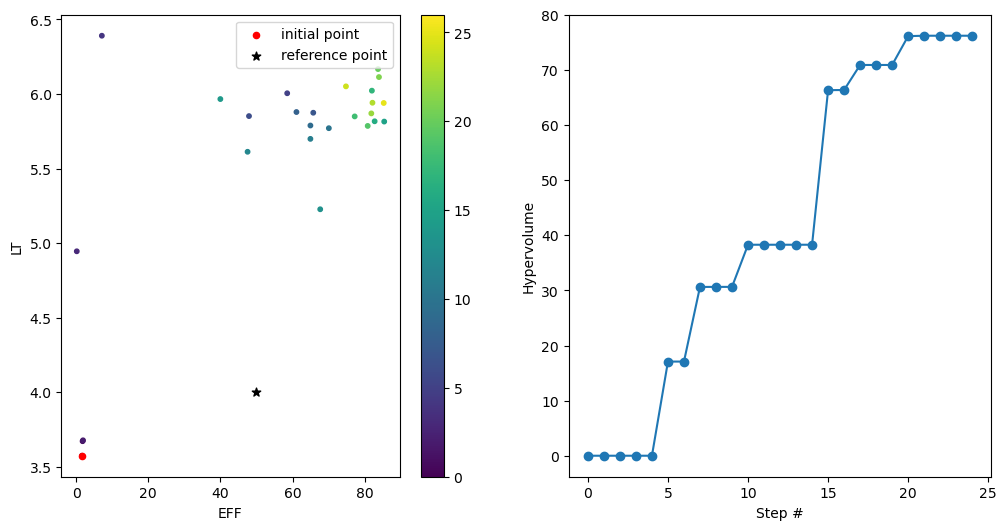

In [25]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

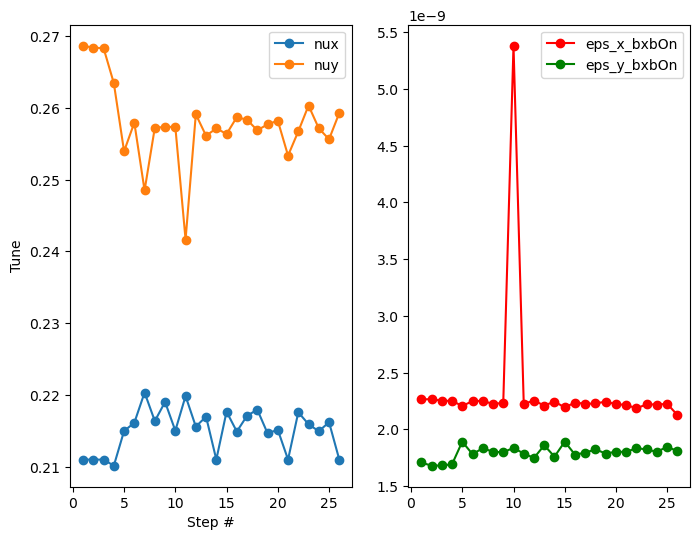

In [26]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [27]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_exp_mobo_{MODE}_v1_dump.json')

'{\n  "optimizer": {\n    "tag": "005e3ea6c5",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "aps_mobo",\n    "n_monte_carlo_samples": 128,\n    "turbo_controller": null,\n    "use_cuda": false,\n    "gp_constructor": {\n      "name": "mobo_model",\n      "use_low_noise_prior": false,\n      "covar_modules": {},\n      "mean_modules": {},\n      "trainable_mean_keys": [],\n      "use_high_noise_prior": false\n    },\n    "numerical_optimizer": {\n      "name": "APSLBFGS",\n      "n_raw_samples": 128,\n      "n_restarts": 10,\n      "max_iter": 2000,\n      "sequential": true\n    },\n    "max_travel_distances": null,\n    "fixed_features": null,\n    "computation_time": null,\n    "n_candidates": 1,\n    "reference_point": {\n      "LT": 4.0,\n      "EFF": 50.0\n    },\n    "prune_inferior_points_kwargs": null\n  },\n  "evaluator": {\n    "name": "func",\n    "on_error": "igno